# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

Let's display general data info and a sample of the data.

In [5]:
# printing the general/summary information about the DataFrame
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
# printing a sample of data
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


For this project we need only review, pos and ds_part columns. All these columns have the correct type and there are no missing values. So, we can proceed.

## EDA

Let's check the number of movies and reviews over years.

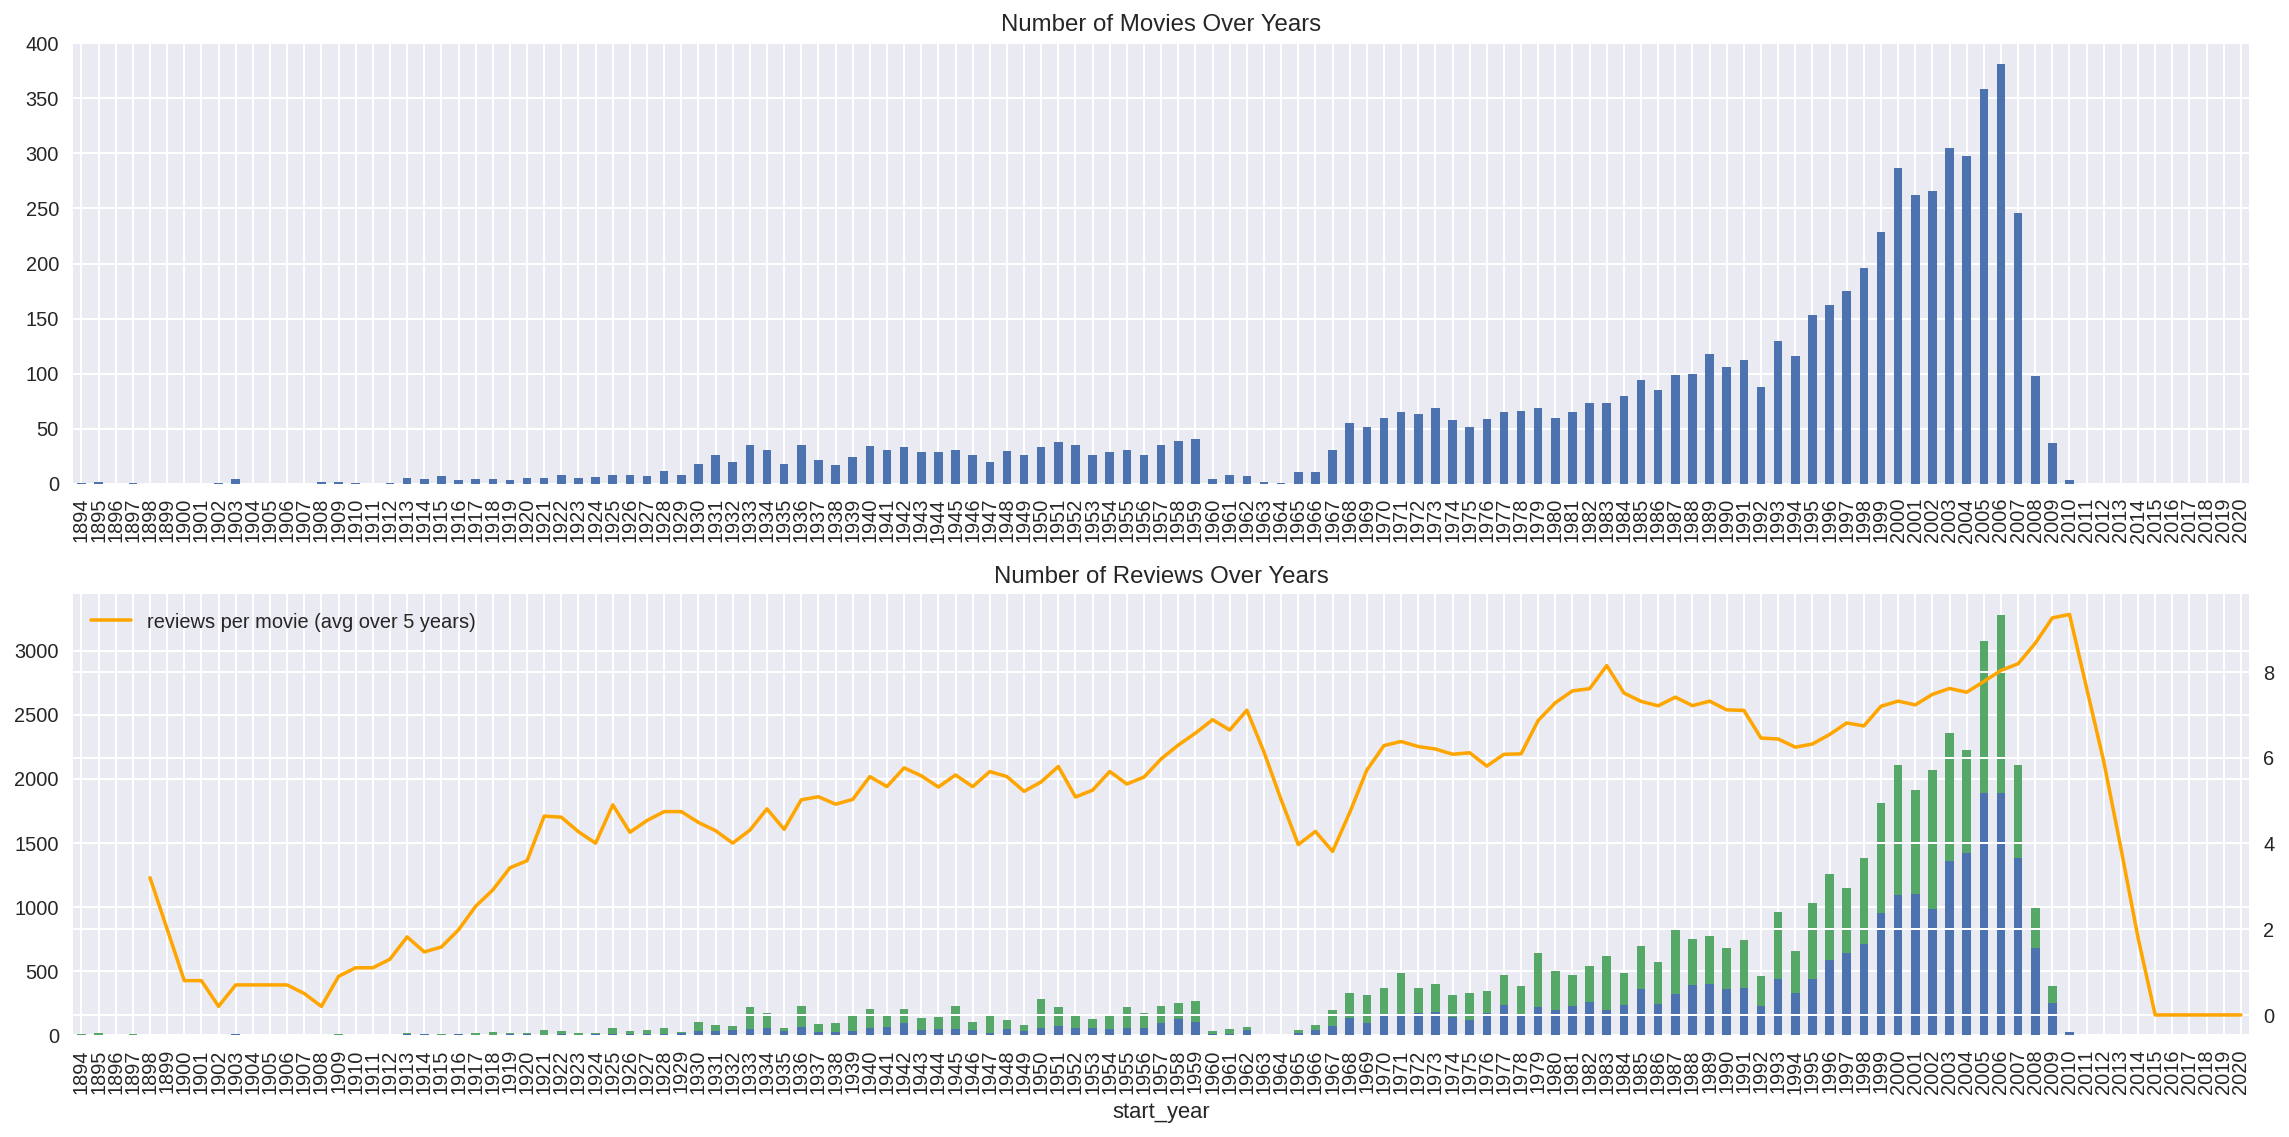

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

As can be seen, the number of movies as well as the number of reviews steadily grew up to the year 2006 and then started to decrease. There is no logical explanation for that decrease and it could be due to that the data set is incomplete for years after 2006.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

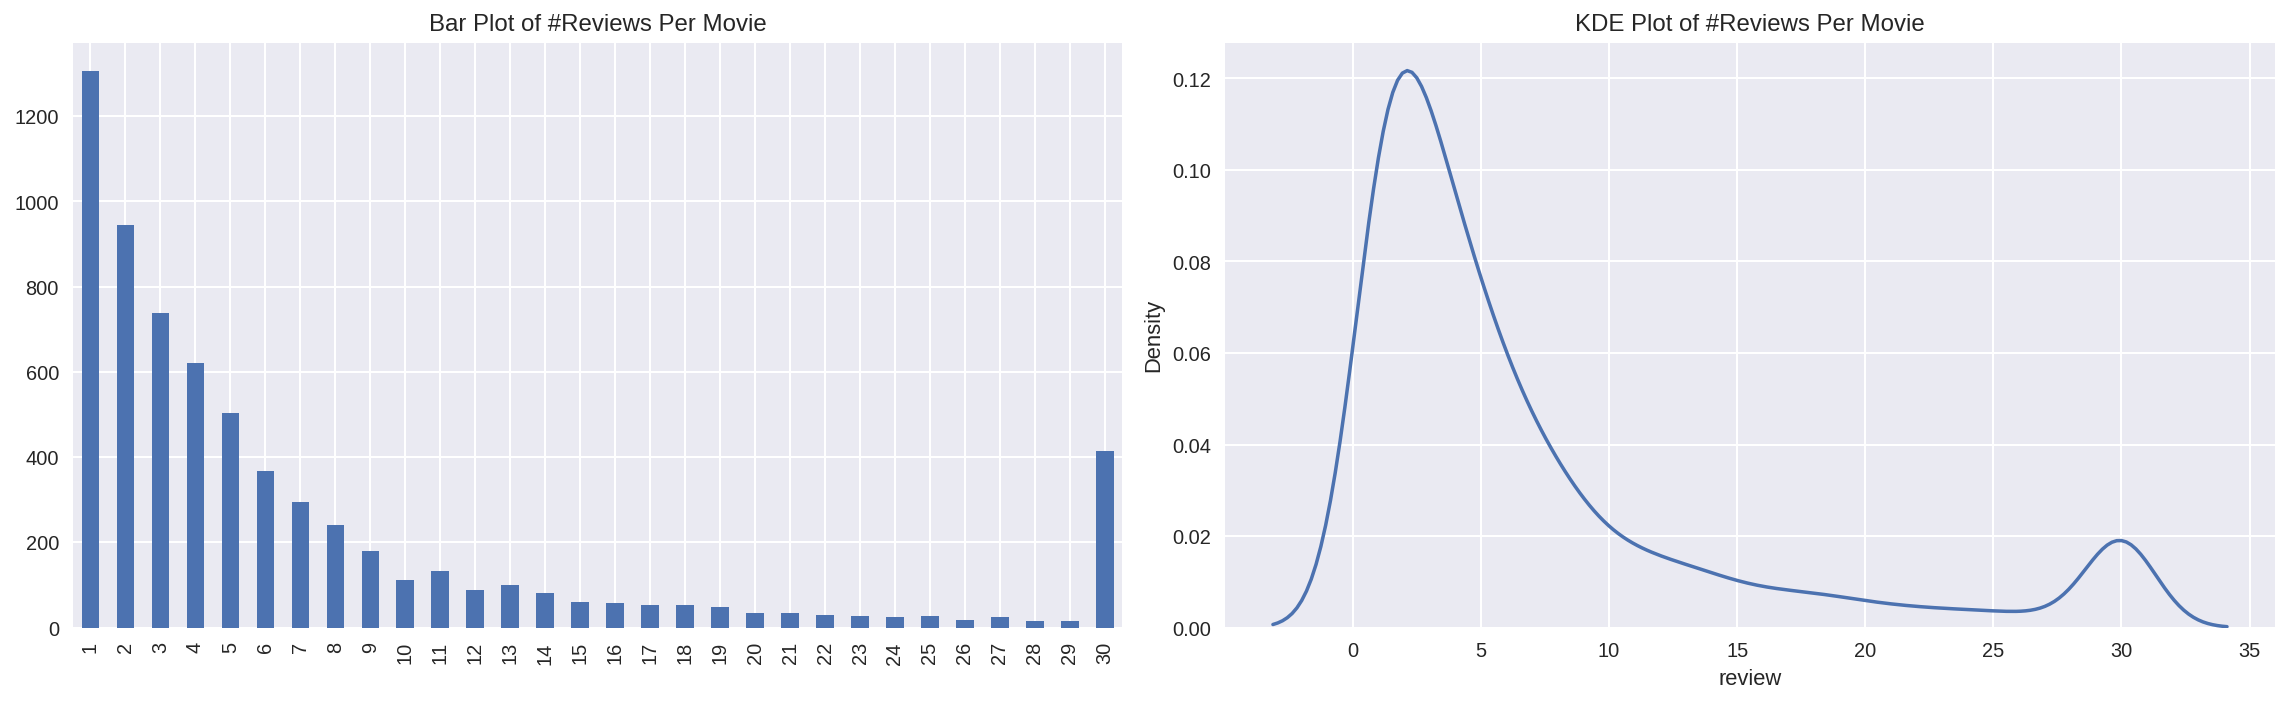

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The number of Reviews Per Movie is steadily decreased. In over words, there are fewer movies with n+1 reviews than movies with n reviews. Surprisingly, there are a lot of movies with 30 reviews. Since there are no movies with more than 30 reviews, probably all movies with 30 and more reviews were put in one category.

Let's check the the class imbalance.

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

There are quite the same numbers of positive and negative reviews, so we can conclude that the classes are balanced.

Let's check the distribution of ratings for train and test data sets.

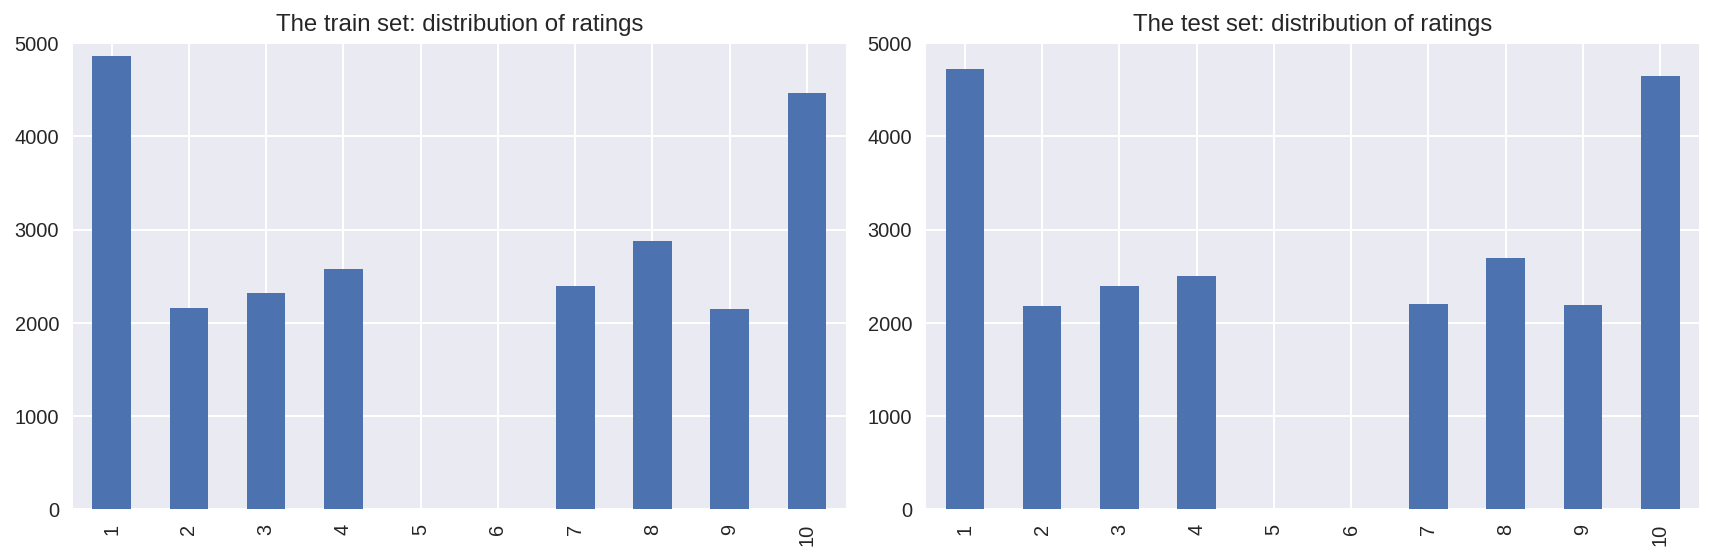

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of ratings for train and test data sets is quite the same.

Let's also check distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


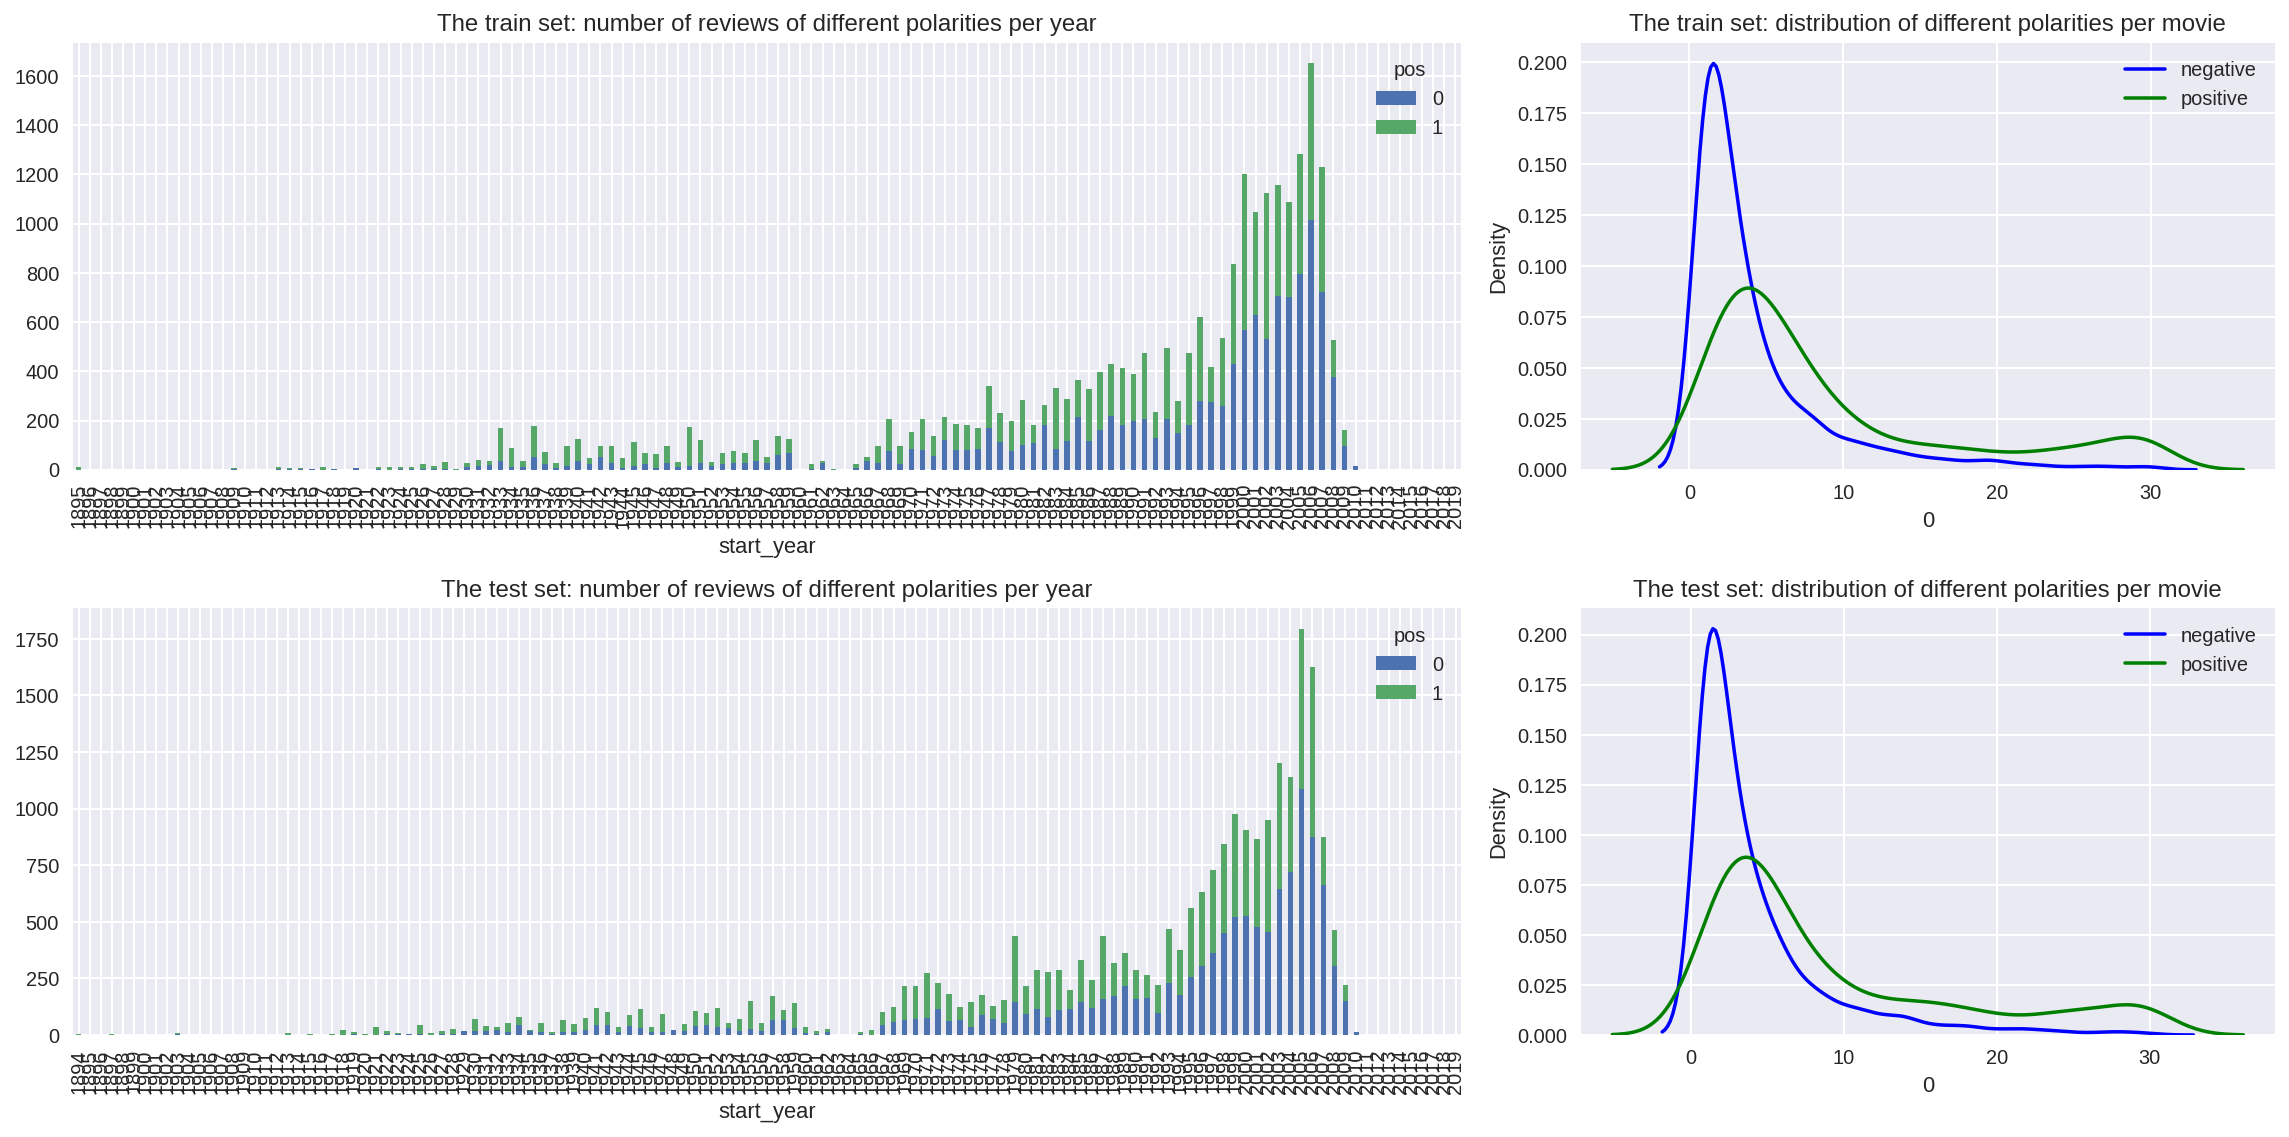

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset is also quite the same.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
#normalizing the reviews
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

#checking the reviews after normaliztion
df_reviews['review_norm'].head(10)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made   presenti...
2    there is no real story the film seems more lik...
3    um      a serious film about troubled teens in...
4    i m totally agree with garryjohal from singapo...
5    this is the first movie i ve seen from singapo...
6    yes non singaporean s can t see what s the big...
7    this true story of carlson s raiders is more o...
8    should have been titled  balderdash   little i...
9    the movie  gung ho    the story of carlson s m...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [15]:
from sklearn.dummy import DummyClassifier

We will use a dummy classifier with a default ”prior” strategy. Since it always returns the most frequent class, the features do not matter. So, we can use dummy features as well.

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


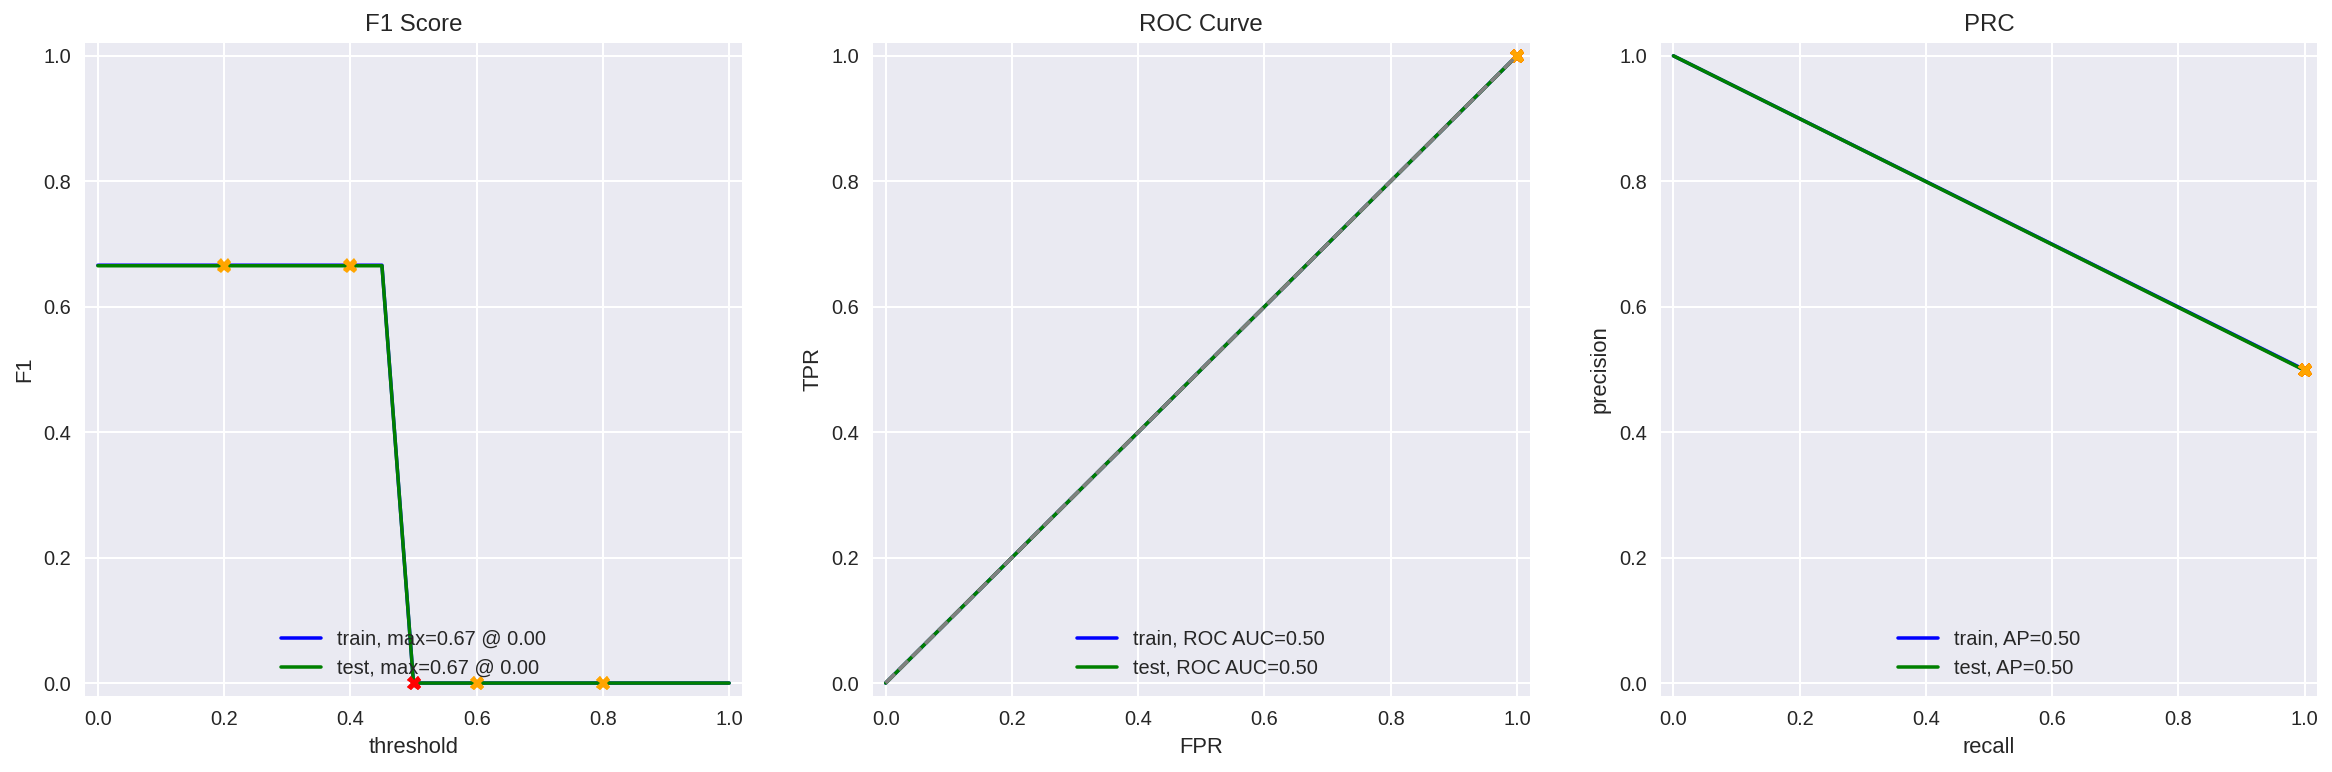

In [16]:
model_0=DummyClassifier()
train_features_0= pd.Series([0]).repeat(len(df_reviews_train))
test_features_0=pd.Series([0]).repeat(len(df_reviews_test))
model_0.fit(train_features_0, train_target)
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

Since the number of positive and negative reviews in the dataset are almost equal, F1 score for dummy classifier with a default ”prior” strategy is 0.5.

### Model 1 - NLTK, TF-IDF and LR

In [17]:
#importing necessary libraries
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [18]:
#defining function to lemmatize the reviews
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]    
    return " ".join(lemmas)

In [19]:
#creating corpusses for train dataset
train_corpus=df_reviews_train['review_norm'].apply(lemmatize)

In [20]:
#creating corpusses for test dataset
test_corpus=df_reviews_test['review_norm'].apply(lemmatize)

In [21]:
#vectorising reviews in train and test datasets
stop_words = set(stopwords.words('english'))
count_tf_idf_1 = TfidfVectorizer(stop_words=stop_words)
train_features_1 = count_tf_idf_1.fit_transform(train_corpus) 
test_features_1 = count_tf_idf_1.transform(test_corpus)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


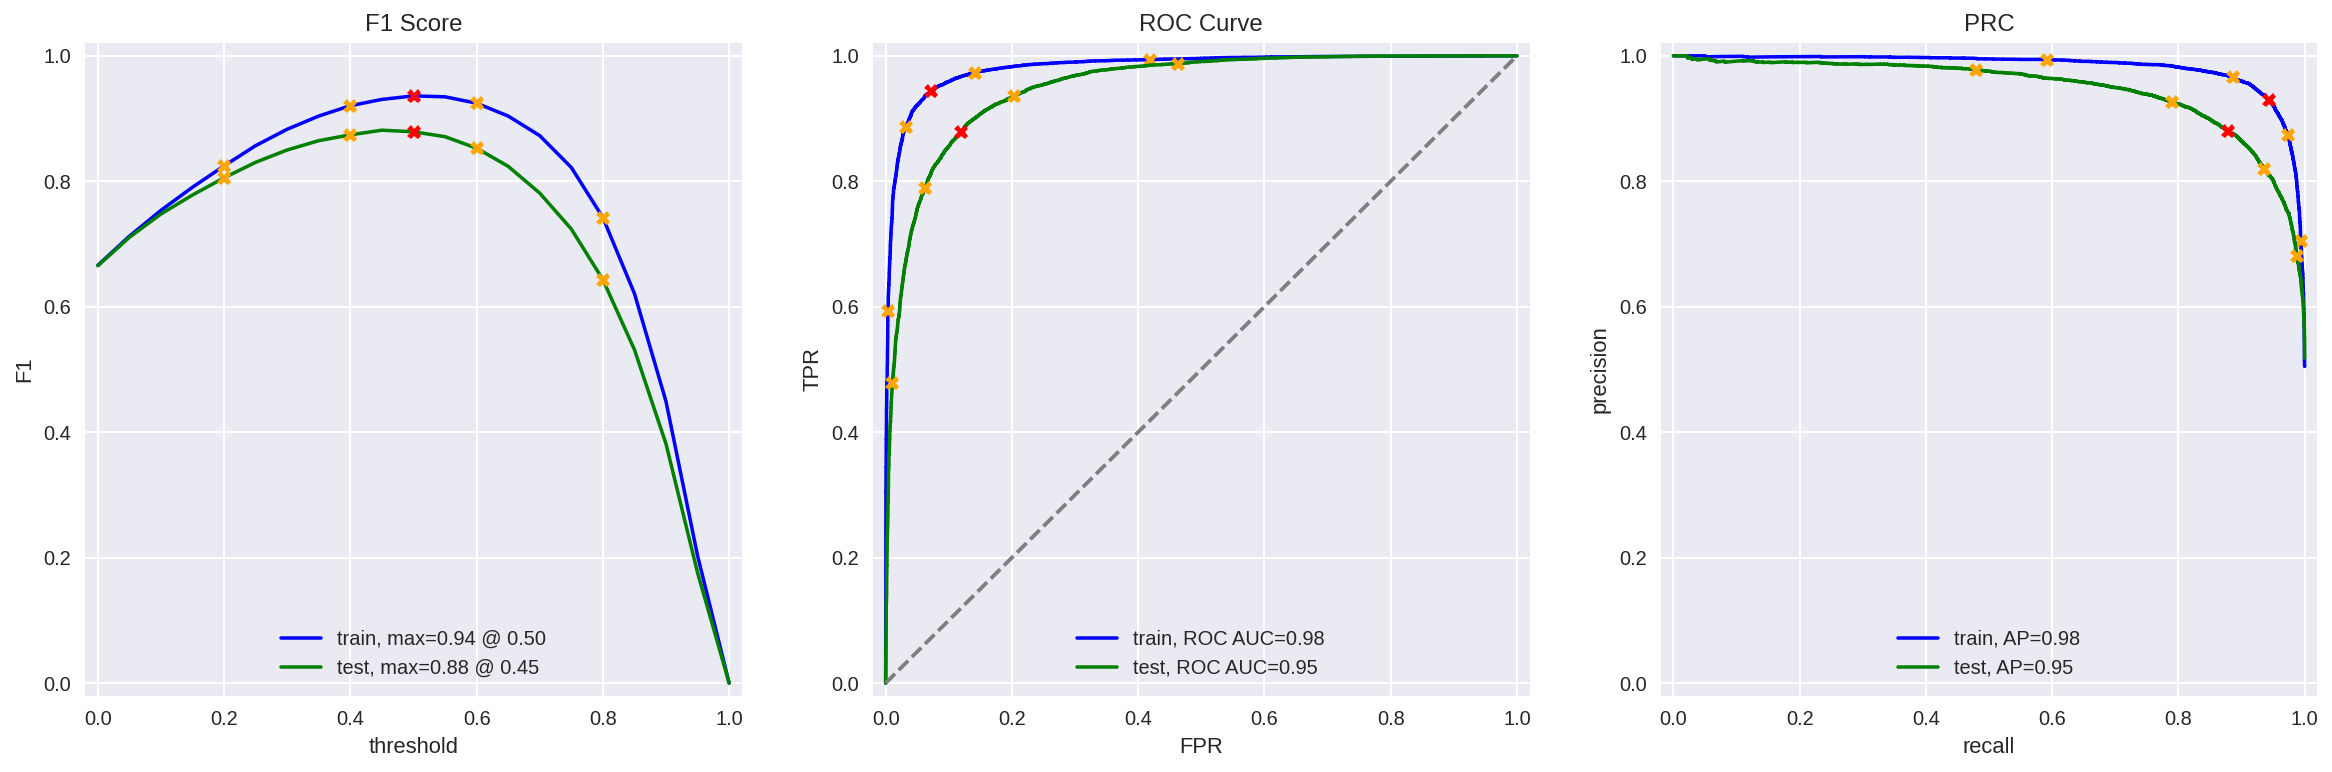

In [22]:
#training LogisticRegression model and evaluating it
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

F1 score for this model is already higher than our threshold (0.85). But let's test other models.

### Model 2 - spaCy, TF-IDF and LR

In [23]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
#defining function to lemmatize the reviews
def text_preprocessing_3(text):    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]       
    return ' '.join(tokens)

In [25]:
#creating corpusses for train dataset
train_corpus=df_reviews_train['review_norm'].apply(text_preprocessing_3)

In [26]:
#creating corpusses for test dataset
test_corpus=df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [27]:
#vectorising reviews in train and test datasets
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words)
train_features_2 = count_tf_idf_2.fit_transform(train_corpus) 
test_features_2 = count_tf_idf_2.transform(test_corpus)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


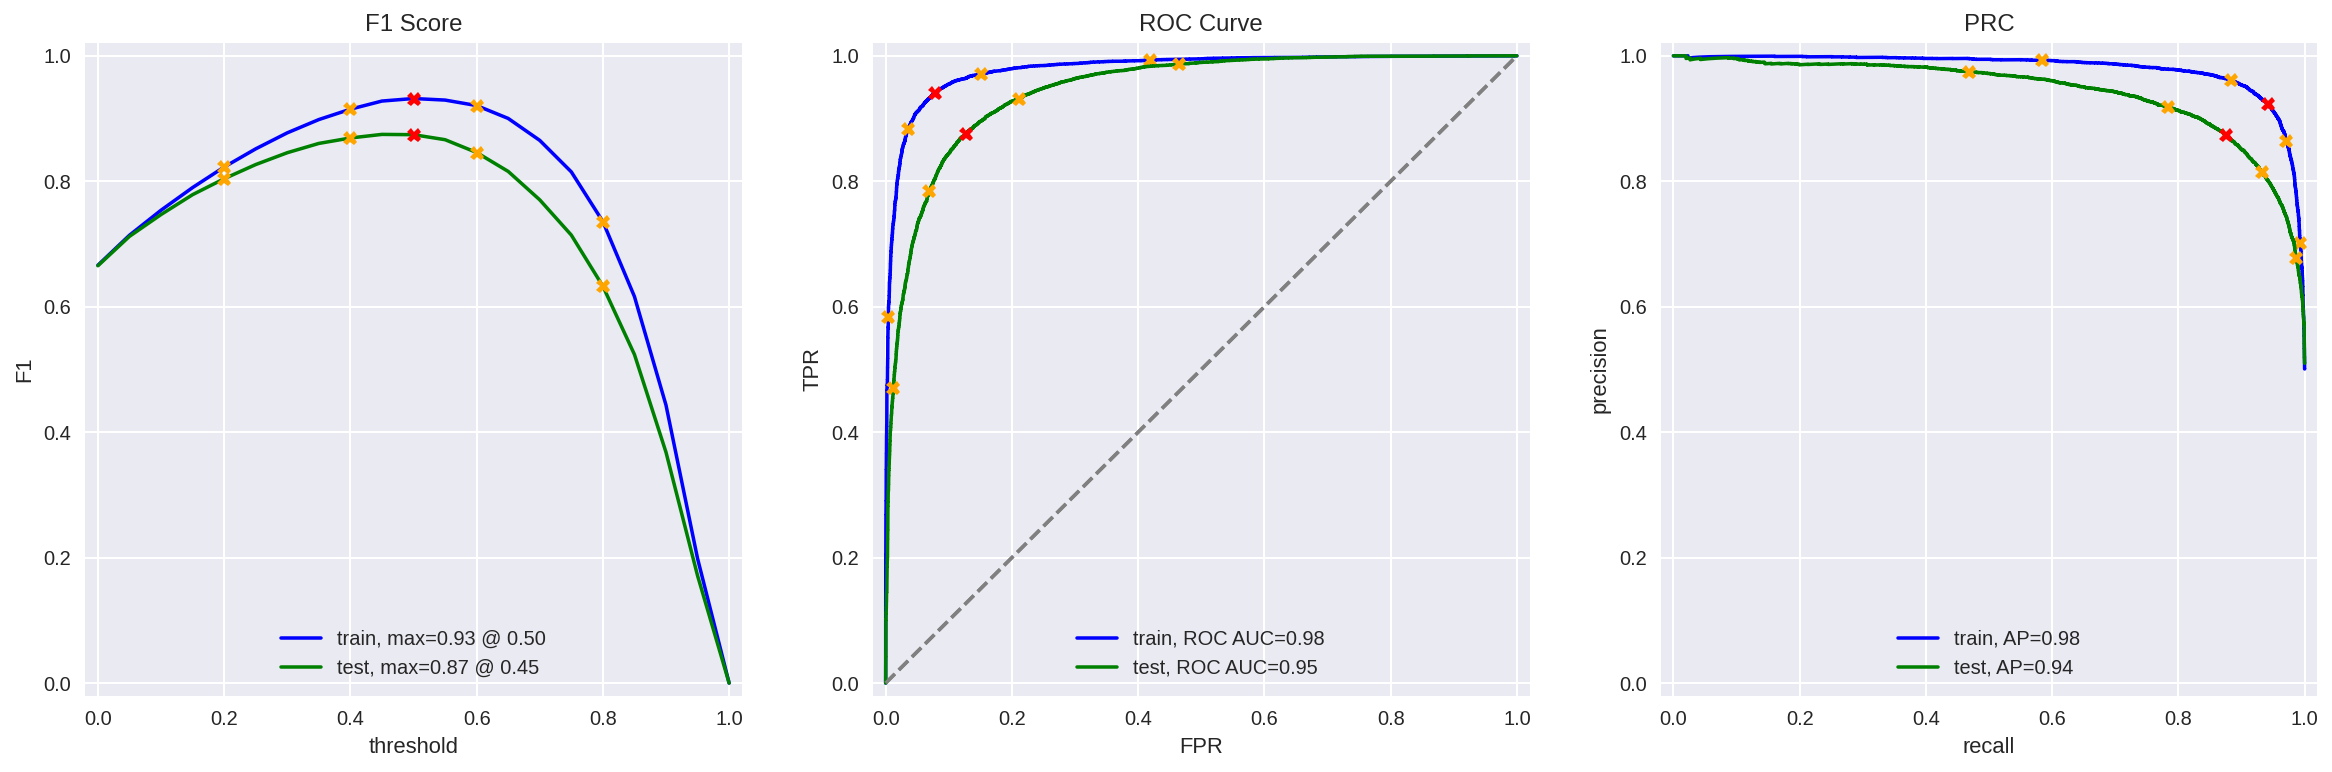

In [28]:
#training LogisticRegression model and evaluating it
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

F1 score for this model is a bit lower than F1 for the previous model, but it is still above the threshold. Let's test one more model.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

Since we use the same lemmatization and vectorization methods as for the previous models, we can reuse datasets from the previous model.

In [29]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
#training LGBM models and tuning parametrs    
model=LGBMClassifier()

#defining parameters for grid search
param={ 'n_estimators': [5, 10, 15],
        'max_depth' : [3, 7, 11],
        'learning_rate': [0.1, 0.5],    
        'objective': ['binary'],
        'random_seed': [12345]}

#finding the best parameters
grid=GridSearchCV(estimator=model, param_grid=param, scoring='f1', cv=3, verbose=0)
grid.fit(train_features_2, train_target)
best_param=grid.best_params_
best_param

In [ ]:
#training LGBM model and evaluating it
model_3=LGBMClassifier(n_estimators=15, max_depth=11, learning_rate=0.5, objective='binary', random_seed=12345)
model_3.fit(train_features_2, train_target)
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

The F1 score for this model is the same as for the previous model. So, Model 1 has the highest F1 score among tested models. Model 3 probably could show a better result if we use the wider range of values for tuning parameters, but it would be very resource consuming and will take a longer time.

## My Reviews

In [ ]:
#defining our own reviews
my_reviews = pd.DataFrame([
    'I did not like this movie.',
    'I was impressed how Bred Pitt played the role of that criminal.',
    'I definetly would not recommed this film to my friends',    
    'I cannot say that I dont like, but the director could pay more attention to small details',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

my_reviews

### Model 1

In [ ]:
#calculating probabilities for our own reviews using model 1
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

The model correctly gives a high probability for negative reviews and a low probability for some positive reviews. But for positive reviews that include the word 'not' probability is incorrectly low. This is probably due to the fact that many negative reviews have this word, and it has a high 'weight'.

### Model 2

In [ ]:
#calculating probabilities for our own reviews using model 2
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

This model mostly shows a similar result, but it incorrectly gives a high probability for the 3rd review. Probably due to different vectorization method, other words have different 'weights'.

### Model 3

In [ ]:
#calculating probabilities for our own reviews using model 1
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

This model incorrectly gives high probability to many negative reviews.

## Conclusions

In this project, we built models for classifying positive and negative reviews for movies. Firstly, we conducted an EDA and concluded that the number of movies as well as the number of reviews steadily grew up to the year 2006 and then started to decrease. There is no logical explanation for that decrease, and it could be due to that the data set is incomplete for years after 2006. We also observed that the distribution of ratings for train and test data sets is quite the same. The distribution of negative and positive reviews over the years for two parts of the dataset is also quite the same.

Then, we normalized, lemmatized, and vectorized the reviews and trained and verified different models. The best F1 score of 0.88 was achieved with the LogisticRegression model where reviews were lemmatized and vectorized using NLTK and TF-IDF.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions